# Experiment on finance data

Dataset used is the currency enchange with respect to USD dollars, from daily measurements from the last 2 years (2017-2018).

Currencies used: 
- Reference: USA
- Canadian dollar (CAD)
- Euro (EUR)
- Japanese yen (JPY)
- Great british pound (GBP)
- Swiss franc (CHF)
- Austrial dollar (AUD)
- Hong Kong dollar (HKD)
- New zealand dollar (NZD)
- South korean won (KRW)
- Mexican peso (MXN)


**Question** how to treat sampling values when input is not time

---

Inflation data 
https://data.oecd.org/price/inflation-cpi.htm


Priors for magnitude:

currency_prior = np.array([1, 1, 3.5, 1, 1, 1, 1, 1, 50., 1])

gonu_prior = np.array([1352., 84.   ,8038.,  128.])

In [3]:
# execute if not installed
import sys
sys.path.insert(0, '../')
import pickle

import mogptk

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

%reload_ext autoreload
%autoreload 2

In [4]:
# plot config
sns.set_context('paper', font_scale=1.4)
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (10, 5)

## Load dataset

In [5]:
df = pd.read_csv('data/finance_datasets/currency_exchange/final_dataset.csv')
cols = list(df)[3:]
cols[0], cols[1] = cols[1], cols[0]
cols

['EUR/USD',
 'CAD/USD',
 'JPY/USD',
 'GBP/USD',
 'CHF/USD',
 'AUD/USD',
 'HKD/USD',
 'NZD/USD',
 'KRW/USD',
 'MXN/USD']

In [6]:
# cut to only 2017
idx = pd.to_datetime(df['Unnamed: 0']) < np.datetime64('2018-01-01')
df = df[idx]

In [7]:
data = []
for c in cols:
    data.append(mogptk.Data(X=df['Day'].values,
                            Y=df[c].values,
                            name=c))
for d in data:
    d.transform(mogptk.TransformDetrend)

## Create and fit model

Remove data to simulate sensor failure

In [8]:
df['Day'].iloc[-1]

362

In [9]:
# randomly sample from the data
for channel in data:
    channel.remove_randomly(pct=0.3)

# drop chunks to simulate sensor failure
last_day = df['Day'].iloc[-1]

data[0].remove_range(last_day, None)
data[1].remove_range(90, 120)
# data[2].remove_range(480, 520)
data[2].remove_range(last_day, None)
data[3].remove_range(200, 250)
data[4].remove_range(None, 30)
# data[5].remove_range(None, 30)
data[5].remove_range(last_day, None)
data[7].remove_range(None, 30)

cols2keep = [0, 2, 5]

for i in range(1, len(cols)):
    if i not in cols2keep:
         data[i].remove_range(last_day - 40, None)

# add pred values

# use data class
x_test = [channel.X[~channel.mask] for channel in data]
y_test = [df[cols[i]].values[~data[i].mask] for i in range(len(cols))]

In [10]:
cols = [c.split('/')[0] for c in cols]

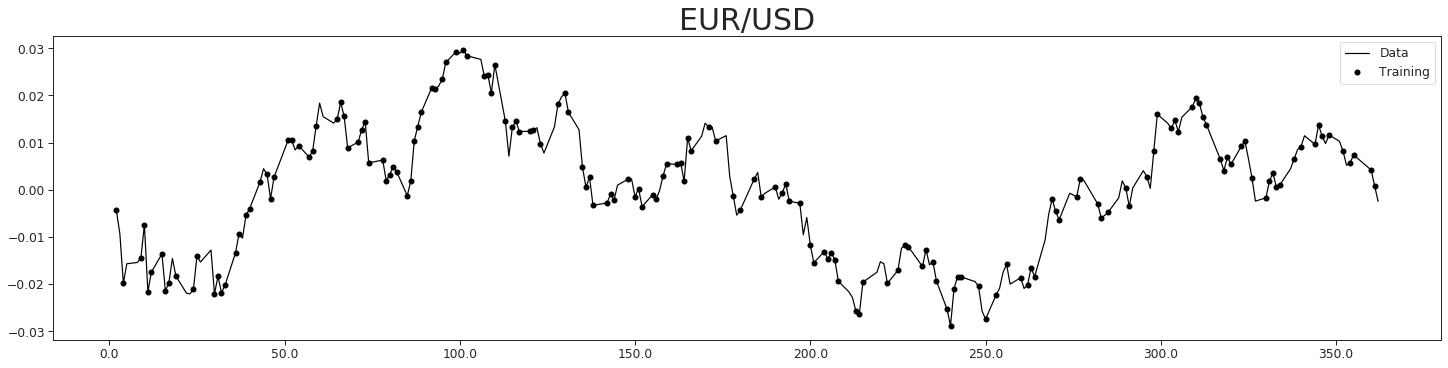

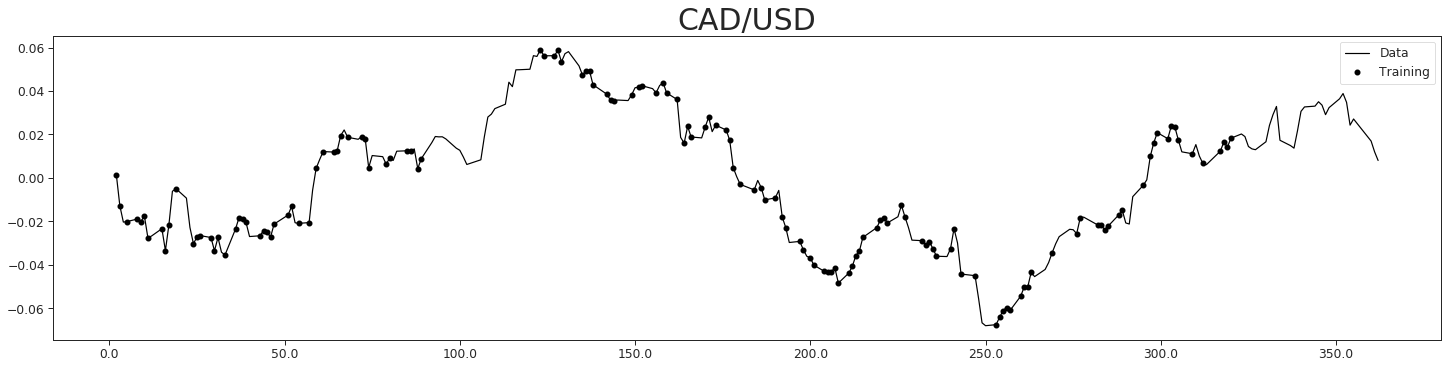

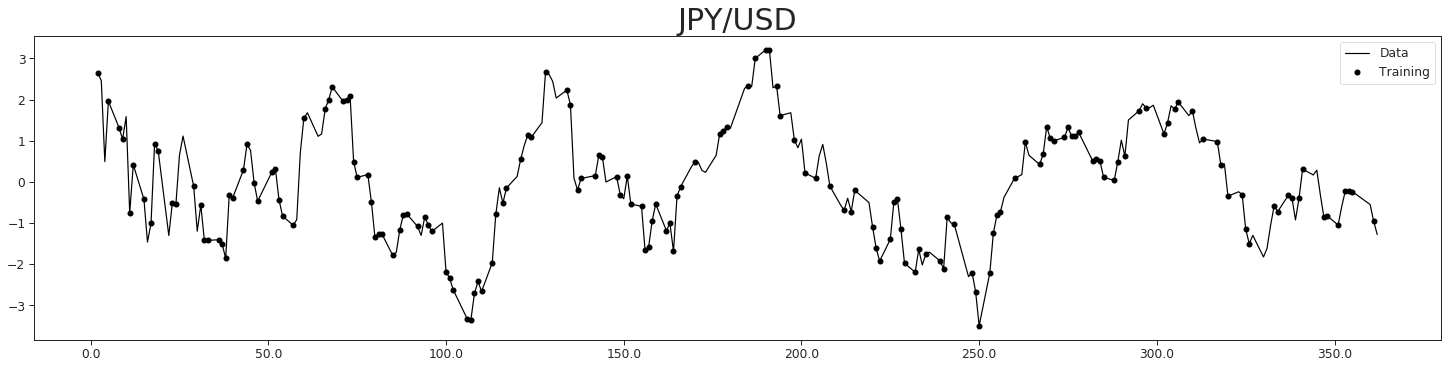

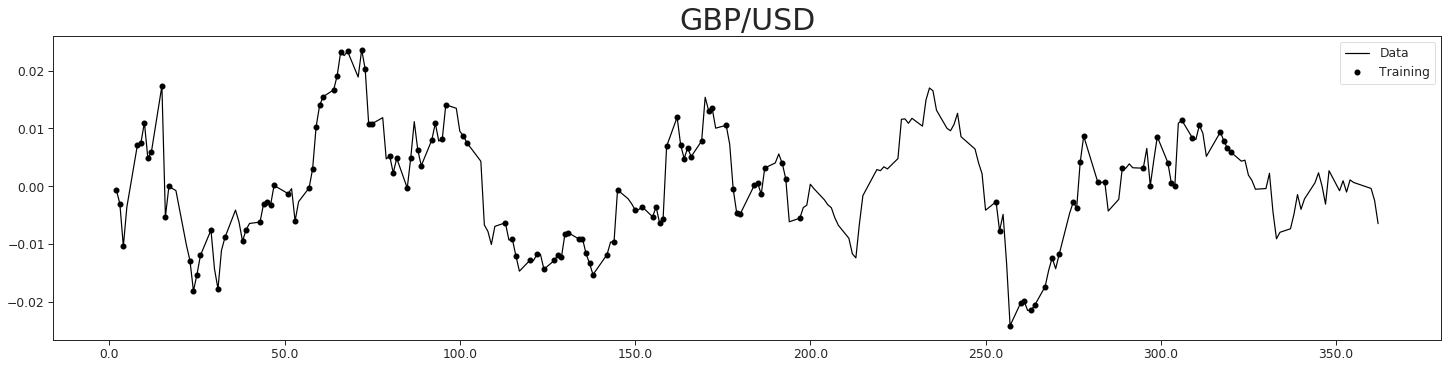

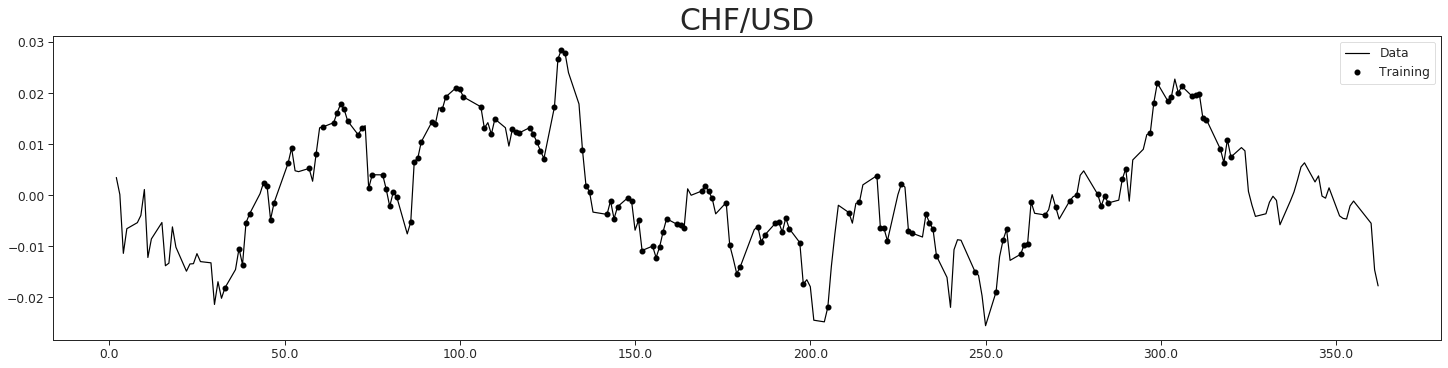

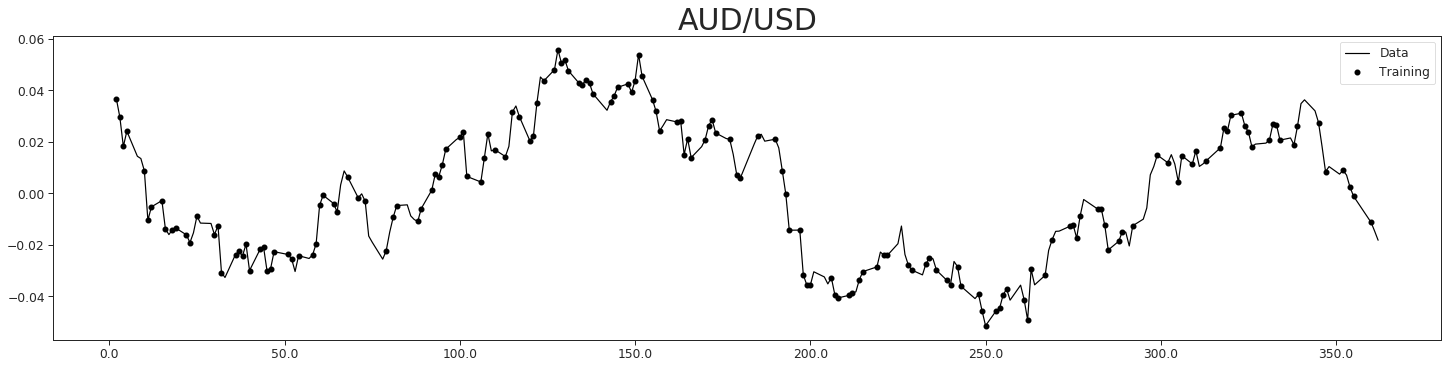

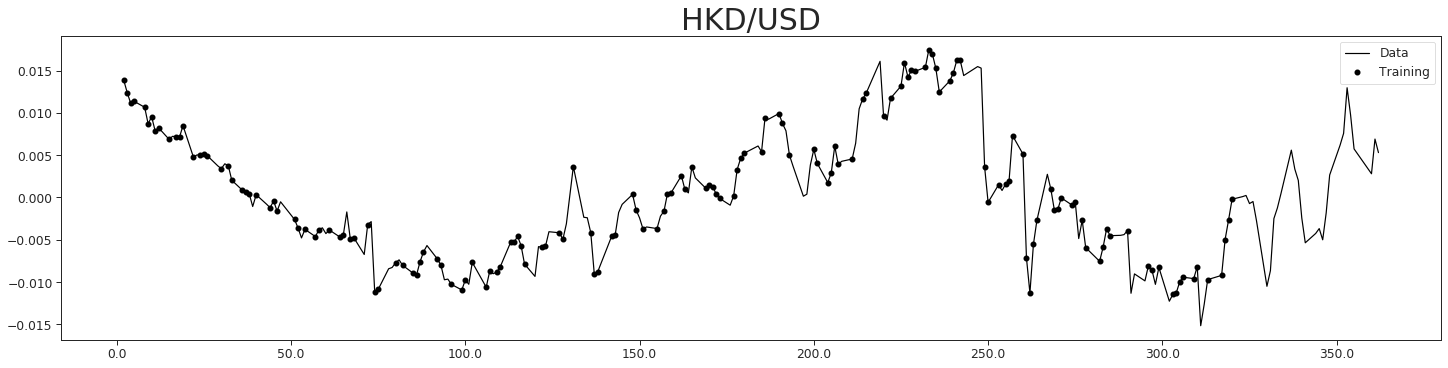

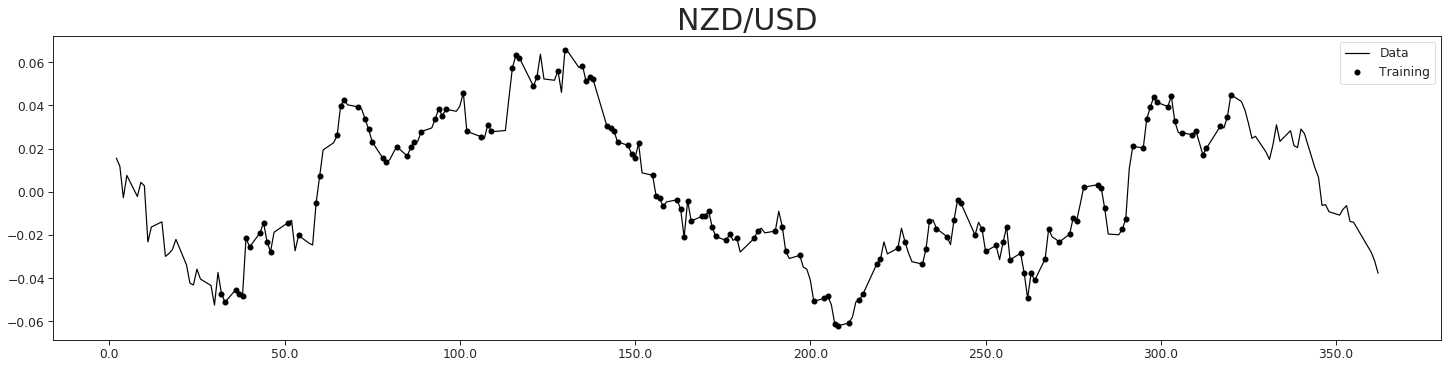

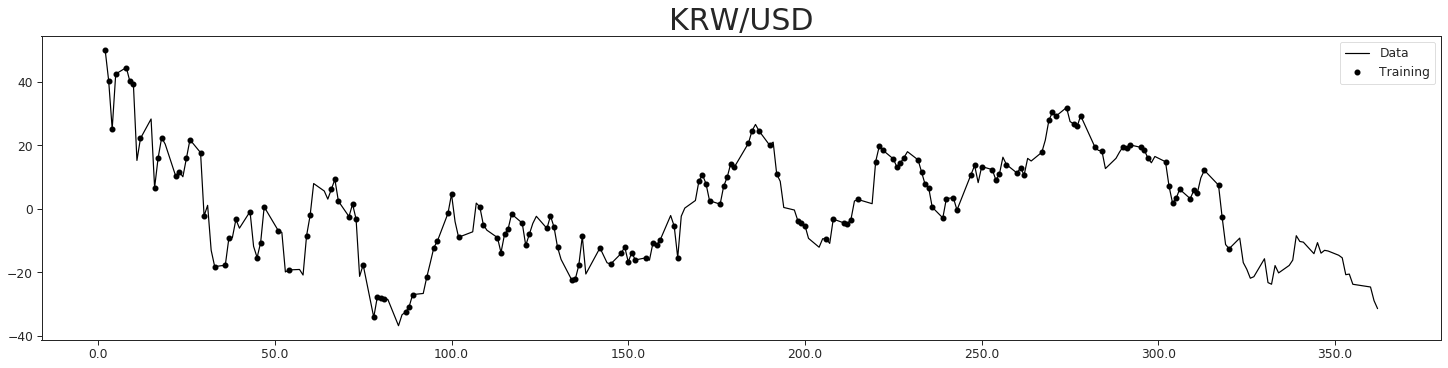

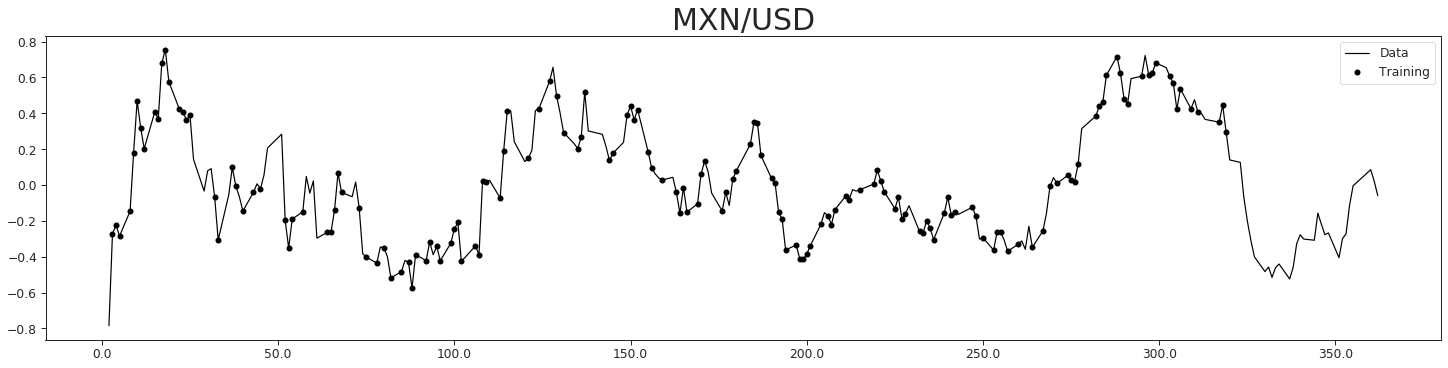

In [8]:
for i in range(10):
    data[i].plot()

## MOSM

warning!!!, long time of execution

In [ ]:
%%time
n_trials = 5

mosm_list = []
mosm_mae = np.zeros((n_trials, len(cols)))
mosm_nmae = np.zeros((n_trials, len(cols)))
mosm_rmse = np.zeros((n_trials, len(cols)))
mosm_nrmse = np.zeros((n_trials, len(cols)))

for n in range(n_trials):
    model_mosm = mogptk.MOSM(data, Q=5)
    model_mosm.init_params('BNSE')
    
    print('Starting trial', n)
    model_mosm.train(method='L-BFGS-B', maxiter=5000, tol=1e-50)
    print('Finished trial', n)
    print('='*50)        
    
    mosm_list.append(model_mosm)
    
    # errors per channel
    error = mogptk.test_errors(model_mosm, x_test=x_test, y_test=y_test)
    
    mosm_mae[n, :] = np.array(error[0])[:, 0]
    mosm_nmae[n, :] = np.array(error[0])[:, 1]
    mosm_rmse[n, :] = np.array(error[0])[:, 2]
    mosm_nrmse[n, :] = np.array(error[0])[:, 3]
    

In [9]:
pd.DataFrame(np.c_[mosm_mae.mean(0), mosm_nmae.mean(0), mosm_rmse.mean(0),
                             mosm_mae.std(0), mosm_nmae.std(0), mosm_rmse.std(0)],
                       columns=['MAE', 'nmae', 'RMSE', 'MAE std', 'nmae% std', 'RMSE std'])

Starting trial 0
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -3592.452321
  Number of iterations: 5000
  Number of functions evaluations: 5281
Done in  59.50262058178584  minutes
Finished trial 0
Starting trial 1
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -3569.629183
  Number of iterations: 5000
  Number of functions evaluations: 5282
Done in  58.46296356916427  minutes
Finished trial 1
Starting trial 2
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -3552.268638
  Number of iterations: 5000
  Number of functions evaluations: 5241
Done in  58.12290994723638  minutes
Finished trial 2
Starting trial 3
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value:

In [73]:
mosm_mae = np.zeros((n_trials, len(cols)))
mosm_nmae = np.zeros((n_trials, len(cols)))
mosm_rmse = np.zeros((n_trials, len(cols)))
mosm_nrmse = np.zeros((n_trials, len(cols)))

for model in mosm_list:

    error = mogptk.test_errors(model, x_test=x_test, y_test=y_test)
    
    mosm_mae[n, :] = np.array(error[0])[:, 0]
    mosm_nmae[n, :] = np.array(error[0])[:, 1]
    mosm_rmse[n, :] = np.array(error[0])[:, 2]
    mosm_nrmse[n, :] = np.array(error[0])[:, 3]

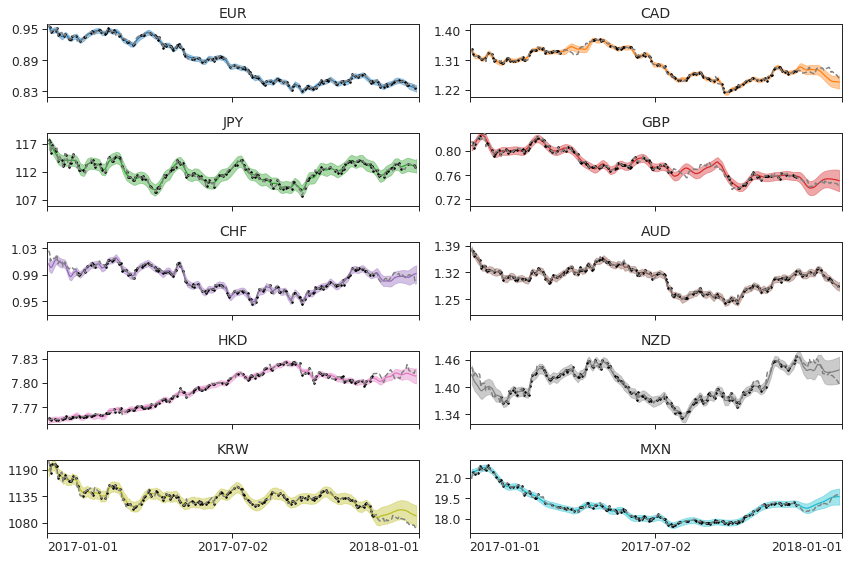

In [74]:
best_model = mosm_list[np.argmin(mosm_nmae.mean(1))]

ylims = [(0.82, .96), (1.20, 1.42),
         (106, 119), (0.71, 0.83),
         (0.93, 1.04), (1.21, 1.4),
         (7.75, 7.84), (1.32, 1.48),
         (1060, 1210), (17, 22.3)]

yticks = [(0.83, .95), (1.22, 1.4),
          (107, 117), (0.72, 0.8),
          (0.95, 1.03), (1.25, 1.39),
          (7.77, 7.83), (1.34, 1.46),
          (1080, 1190), (18, 21)]


ylims2 = [(0.82, .89), (1.20, 1.32),
         (106, 116), (0.72, 0.79),
         (0.93, 1.01), (1.21, 1.35),
         (7.795, 7.835), (1.32, 1.49),
         (1060, 1170), (17, 20)]

yticks2 = [(0.83, .87), (1.21, 1.31),
           (107, 115), (0.73, 0.78),
           (0.95, 0.99), (1.23, 1.33),
           (7.80, 7.83), (1.35, 1.45),
           (1080, 1150), (17.5, 19.5)]


f, axarr, data_dict = mogptk.plot_prediction(best_model,
                       grid=(5, 2),
                       names=cols,
                       title='',
                       ylims=ylims,
                       figsize=(12, 8));

for i in range(len(cols)):
    axarr[i].set_title(cols[i], fontsize=14)
    axarr[i].set_yticks(np.linspace(yticks[i][0], yticks[i][1], 3))

    channel = best_model.data[i]

    # xlabels = pd.date_range(df['Unnamed: 0'].iloc[0], df['Unnamed: 0'].iloc[-1], periods=9).date
    # xticks = [formatter._parse(str(label)) for label in xlabels]
    
    xlabels = pd.date_range('2017-01-01', '2018-01-01', periods=3)
    xticks = (xlabels - np.datetime64('2017-01-01')).days.values
    
    new_xlabels = xlabels.date
    # new_xlabels[1::2] = ['']
    # xlabels[::2][2:] += datetime.timedelta(days=1)
    # new_xlabels[::2] = xlabels[::2]
    
    axarr[i].set_xticks(xticks)
    if i>= 8:
         axarr[i].set_xticklabels(new_xlabels)
    else:
         axarr[i].set_xticklabels([])

    axarr[i].set_xlim(xticks[0], xticks[-1])
    
    xlabel_list = [item for item in axarr[i].get_xticklabels()]
    if i>=8:
        xlabel_list[0].set_ha('left')
        xlabel_list[-1].set_ha('right')
plt.tight_layout()

# plt.savefig('output/mosm_exchange_rate_zoomed.pdf', bbox_inches='tight')
# plt.savefig('output/mosm_exchange_rate.pdf', bbox_inches='tight')

In [77]:
import pickle
mosm_errors = []

for model in mosm_list:
    mosm_errors.append(mogptk.test_errors(model, x_test=x_test, y_test=y_test, raw_errors=True))
    
    
with open('output/mosm_errors.pickle', 'wb') as handle:
    pickle.dump(mosm_errors, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('output/mosm_figure_data.pickle', 'wb') as handle:
    pickle.dump(data_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [81]:
with open('output/mosm_errors.pickle', 'rb') as handle:
    test = pickle.load(handle)
    


In [12]:
model_mosm.get_cross_params()['delay'][:, :, 0, :].max()

2.91640162839039

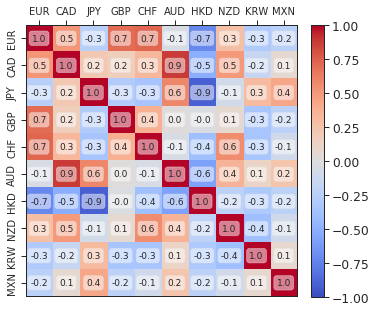

In [68]:
f, ax, im, corr_matrix = best_model.plot_correlations(9)
ax.set_yticks(np.arange(10));
ax.set_yticklabels(cols, fontsize=10, rotation=90, va='center');
ax.set_xticks(np.arange(10));
ax.set_xticklabels(cols, fontsize=10);
ax.xaxis.set_ticks_position('top')

cbaxes = f.add_axes([0.72, 0.124, 0.018, 0.755])
f.colorbar(im, cax=cbaxes)

# plt.tight_layout()
plt.savefig('output/corr_currency.pdf', bbox_inches='tight')

## CSM

In [10]:
%%time
n_trials = 5

csm_mae = np.zeros((n_trials, len(cols)))
csm_nmae = np.zeros((n_trials, len(cols)))
csm_rmse = np.zeros((n_trials, len(cols)))
csm_nrmse = np.zeros((n_trials, len(cols)))

csm_list = []

for n in range(n_trials):
    model_csm = mogptk.CSM(data, Q=5)
    model_csm.init_params('BNSE')
    
    print('Starting trial', n)
    model_csm.train(method='L-BFGS-B', maxiter=5000, tol=1e-15)
    print('Finished trial', n)
    print('='*50)
    csm_list.append(model_csm)
    
    # errors per channel
    error = mogptk.test_errors(model_csm, x_test=x_test, y_test=y_test)
    
    csm_mae[n, :] = np.array(error[0])[:, 0]
    csm_nmae[n, :] = np.array(error[0])[:, 1]
    csm_rmse[n, :] = np.array(error[0])[:, 2]
    csm_nrmse[n, :] = np.array(error[0])[:, 3]

KeyboardInterrupt: 

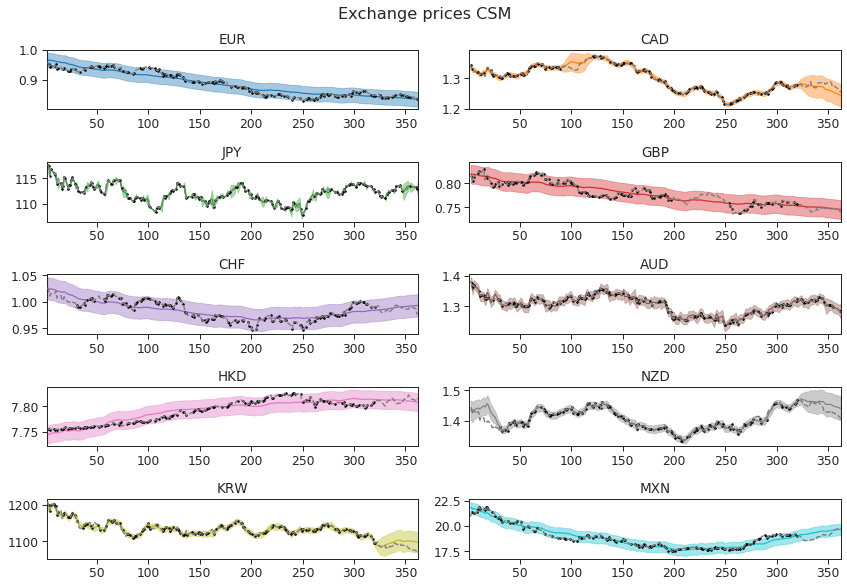

In [100]:
best_csm = csm_list[np.argmin(csm_nmae.mean(1))]

mogptk.plot_prediction(model_csm, grid=(5, 2), names=cols, title='Exchange prices CSM');

In [101]:
csm_errors = []

for model in csm_list:
    csm_errors.append(mogptk.test_errors(model, x_test=x_test, y_test=y_test, raw_errors=True))
    
    
with open('output/csm_errors.pickle', 'wb') as handle:
    pickle.dump(csm_errors, handle, protocol=pickle.HIGHEST_PROTOCOL)

## SM-LMC

In [11]:
%%time
n_trials = 5

smlmc_mae = np.zeros((n_trials, len(cols)))
smlmc_nmae = np.zeros((n_trials, len(cols)))
smlmc_rmse = np.zeros((n_trials, len(cols)))
smlmc_nrmse = np.zeros((n_trials, len(cols)))

smlmc_list = []

for n in range(n_trials):
    print('Trial ', n)
    model_smlmc = mogptk.SM_LMC(data, Q=5)
    model_smlmc.init_params('BNSE')
    
    model_smlmc.train(method='L-BFGS-B', maxiter=5000, tol=1e-50)
    
    smlmc_list.append(model_smlmc)
    
    error = mogptk.test_errors(model_smlmc, x_test=x_test, y_test=y_test)
    
    smlmc_mae[n, :] = np.array(error[0])[:, 0]
    smlmc_nmae[n, :] = np.array(error[0])[:, 1]
    smlmc_rmse[n, :] = np.array(error[0])[:, 2]
    smlmc_nrmse[n, :] = np.array(error[0])[:, 3]

Trial  0
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -3029.097277
  Number of iterations: 5000
  Number of functions evaluations: 5253
Done in  25.85756880044937  minutes
Trial  1
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -3110.994466
  Number of iterations: 5000
  Number of functions evaluations: 5269
Done in  25.07077535788218  minutes
Trial  2
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -3048.330257
  Number of iterations: 5000
  Number of functions evaluations: 5257
Done in  25.054150398572286  minutes
Trial  3
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -3041.026574
  Number of iterations: 5000
  Number of functions evaluations: 5283

In [12]:
pd.DataFrame(np.c_[smlmc_mae.mean(0), smlmc_nmae.mean(0), smlmc_rmse.mean(0),
                   smlmc_mae.std(0), smlmc_nmae.std(0), smlmc_rmse.std(0)],
             columns=['MAE', 'nmae%', 'RMSE', 'MAE std', 'nmae% std', 'RMSE std'])

,MAE,nmae%,RMSE,MAE std,nmae% std,RMSE std
0,0.002743,0.003109,0.003433,0.000149,0.000169,0.000187
1,0.008451,0.006494,0.010917,0.000973,0.000748,0.001433
2,0.554962,0.004934,0.697228,0.137768,0.001225,0.154452
3,0.007726,0.010042,0.010536,0.000489,0.000635,0.000924
4,0.006432,0.006531,0.008520,0.000717,0.000728,0.000766
5,0.005331,0.004098,0.006690,0.000182,0.000140,0.000210
6,0.004268,0.000547,0.005536,0.000372,0.000048,0.000573
7,0.018130,0.012834,0.027062,0.003006,0.002128,0.004288
8,5.994680,0.005356,8.333665,0.834982,0.000746,1.238814
9,0.239106,0.012580,0.306940,0.038790,0.002041,0.043100


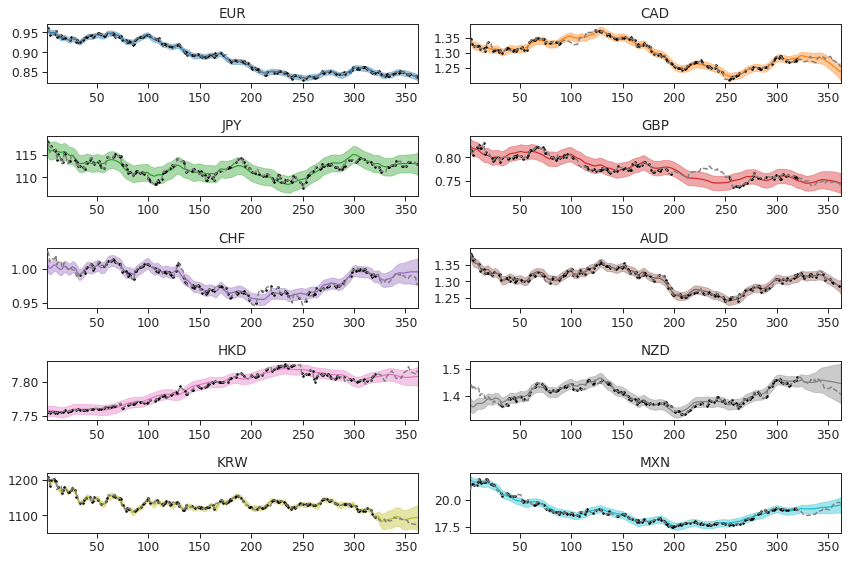

In [14]:
best_smlmc = smlmc_list[np.argmin(smlmc_nmae.mean(1))]
mogptk.plot_prediction(best_smlmc,
                       grid=(5, 2),
                       names=cols,
                       title='',
                       figsize=(12, 8));

In [16]:
import pickle

smlmc_errors = []

for model in smlmc_list:
    smlmc_errors.append(mogptk.test_errors(model, x_test=x_test, y_test=y_test, raw_errors=True))
    
    
with open('output/smlmc_errors.pickle', 'wb') as handle:
    pickle.dump(smlmc_errors, handle, protocol=pickle.HIGHEST_PROTOCOL)

## IGP
Independant gaussian process with spectral mixture kernel

In [31]:
%%time
n_trials = 5

igp_mae = np.zeros((n_trials, len(cols)))
igp_nmae = np.zeros((n_trials, len(cols)))
igp_rmse = np.zeros((n_trials, len(cols)))
igp_nrmse = np.zeros((n_trials, len(cols)))

for n in range(n_trials):
    print('Trial ', n)
    
    igp_list = []
    
    for i in range(len(cols)):
        
        data[i].X = data[i].X.astype(float)
        
        model_sm = mogptk.SM(data[i], Q=3)
        model_sm.init_params('BNSE')
        model_sm.train(method='L-BFGS-B', maxiter=5000, tol=1e-50)
        
        igp_list.append(model_sm)
        
        error = mogptk.test_errors(model_sm, x_test=[x_test[i]], y_test=[y_test[i]])
    
        igp_mae[n, i] = np.array(error[0])[:, 0]
        igp_nmae[n, i] = np.array(error[0])[:, 1]
        igp_rmse[n, i] = np.array(error[0])[:, 2]
        igp_nrmse[n, i] = np.array(error[0])[:, 3]
    print('='*50)

Trial  0
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -683.105708
  Number of iterations: 71
  Number of functions evaluations: 100
Done in  0.024032668272654215  minutes
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -511.517584
  Number of iterations: 91
  Number of functions evaluations: 134
Done in  0.012774423758188883  minutes
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 187.455190
  Number of iterations: 82
  Number of functions evaluations: 96
Done in  0.011267900466918945  minutes
INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: -518.335233
  Number of iterations: 107
  Number of functions evaluations: 189
Done in  0.014606706301371257  minut

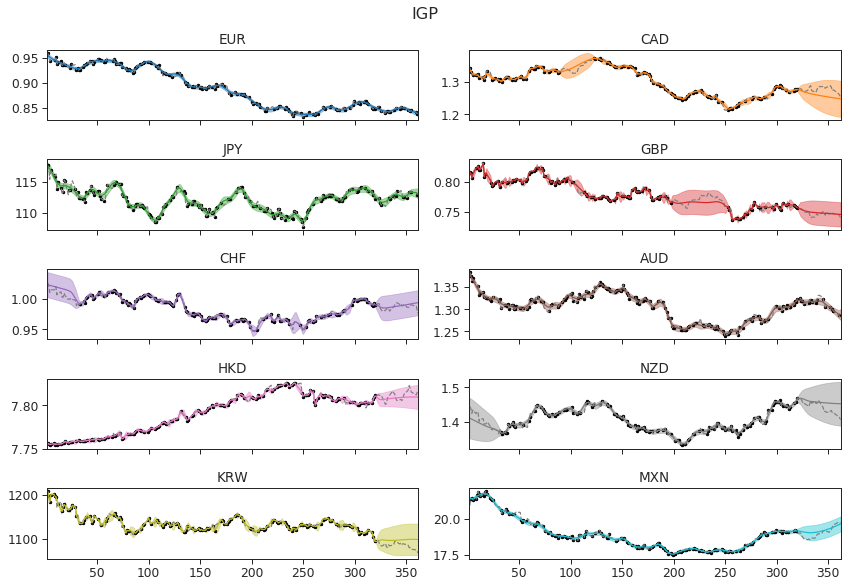

In [18]:
f, axarr = plt.subplots(5, 2, sharex=True, figsize=(12, 8))
axarr = axarr.reshape(-1)

for i in range(len(cols)):
    c = igp_list[i].data[0]
    x_train = c.X[c.mask]
    y_train = mogptk.data._detransform(c.transformations, c.X[c.mask], c.Y[c.mask])
    
    x_all = c.X
    y_all = mogptk.data._detransform(c.transformations, c.X, c.Y)
    
    x_pred = c.X
    mean_pred, lower_ci, upper_ci = igp_list[i].predict([x_pred])
    
    axarr[i].plot(x_train[:, 0], y_train, '.k', label='Train', )
    axarr[i].plot(x_all[:, 0], y_all, '--', label='Test', c='gray')

    axarr[i].plot(x_pred[:, 0], mean_pred[0], label='Post.Mean', c=sns.color_palette()[i%10])
    axarr[i].fill_between(x_pred[:, 0].reshape(-1),
                          lower_ci[0],
                          upper_ci[0],
                          label='95% c.i',
                          color=sns.color_palette()[i%10],
                          alpha=0.4)

    # axarr[i].legend(ncol=4, loc='upper center', fontsize=8)
    axarr[i].set_xlim(x_all[0]-1, x_all[-1])

    # set channels name
    
    axarr[i].set_title(cols[i])

plt.suptitle('IGP', y=1.02)
plt.tight_layout()

## Compare All

In [111]:
print('{:.3e}, {:.3e}'.format(mosm_nmae[:, :].mean(),
      csm_nmae[:, :].mean())
      #smlmc_nmae[:, :].mean(),
      #igp_nmae[:, :].mean()
     )

9.314e-04, 7.821e-03


In [19]:
print('nMAE: smlmc {:.3e} pm {:.3e} | igp {:.3e} pm {:.3e}'.format(
        smlmc_nmae[:, :].mean(),
        smlmc_nmae[:, :].std(),
        igp_nmae[:, :].mean(),
        igp_nmae[:, :].std(),
    )
     )

nMAE: smlmc 6.653e-03 pm 3.977e-03 | igp 4.703e-03 pm 2.036e-03


In [20]:
print('nRMSE: smlmc {:.3e} pm {:.3e} | igp {:.3e} pm {:.3e}'.format(
        smlmc_nrmse[:, :].mean(),
        smlmc_nrmse[:, :].std(),
        igp_nrmse[:, :].mean(),
        igp_nrmse[:, :].std(),
    )
     )

nRMSE: smlmc 8.943e-03 pm 5.635e-03 | igp 6.397e-03 pm 2.935e-03


In [112]:
print('{:.3e}, {:.3e}'.format(mosm_nmae[:, :].std(),
      csm_nmae[:, :].std())
      #smlmc_nmae[:, :].std(),
      #igp_nmae[:, :].std()
     )

2.114e-03, 4.535e-03


In [113]:
print('{:.3e}, {:.3e}'.format(mosm_nrmse[:, :].mean(),
      csm_nrmse[:, :].mean())
      #smlmc_nrmse[:, :].mean(),
      #igp_nrmse[:, :].mean()
     )

1.281e-03, 1.004e-02


In [114]:
print('{:.3e}, {:.3e}'.format(mosm_nrmse[:, :].std(),
      csm_nrmse[:, :].std())
      #smlmc_nrmse[:, :].std(),
      #igp_nrmse[:, :].std()
     )

2.953e-03, 5.543e-03


# Load errors

In [33]:
mosm_nmae.mean()

0.004834640245845033

In [21]:
with open('output/mosm_errors.pickle', 'rb') as handle:
    mosm_errors = pickle.load(handle)

n_trials = 5

mosm_nmae = np.zeros((n_trials, len(cols)))
mosm_nrmse = np.zeros((n_trials, len(cols)))

for n in range(n_trials):
    for i in range(len(cols)):
        error = mosm_errors[n][0][i]
            
        mosm_nmae[n, i] = np.abs(error).mean() / y_test[i].mean()
        mosm_nrmse[n, i] = np.sqrt((error**2).mean()) / y_test[i].mean()
        
print('mosm nMAE {:.3e} pm {:.3e} | mosm nRMSE {:.3e} pm {:.3e}'.format(
        mosm_nmae.mean(1).mean(),
        mosm_nmae.mean(1).std(),
        mosm_nrmse.mean(1).mean(),
        mosm_nrmse.mean(1).std()))

mosm nMAE 4.835e-03 pm 2.809e-04 | mosm nRMSE 6.538e-03 pm 4.152e-04


In [22]:
with open('output/csm_errors.pickle', 'rb') as handle:
    csm_errors = pickle.load(handle)

n_trials = 5

csm_nmae = np.zeros((n_trials, len(cols)))
csm_nrmse = np.zeros((n_trials, len(cols)))

for n in range(n_trials):
    for i in range(len(cols)):
        error = csm_errors[n][0][i]
            
        csm_nmae[n, i] = np.abs(error).mean() / y_test[i].mean()
        csm_nrmse[n, i] = np.sqrt((error**2).mean()) / y_test[i].mean()
        
print('csm nMAE {:.3e} pm {:.3e} | csm nRMSE {:.3e} pm {:.3e}'.format(
        csm_nmae.mean(1).mean(),
        csm_nmae.mean(1).std(),
        csm_nrmse.mean(1).mean(),
        csm_nrmse.mean(1).std()))

csm nMAE 7.821e-03 pm 1.308e-03 | csm nRMSE 1.004e-02 pm 1.597e-03


In [23]:
with open('output/smlmc_errors.pickle', 'rb') as handle:
    smlmc_errors = pickle.load(handle)

n_trials = 5

smlmc_nmae = np.zeros((n_trials, len(cols)))
smlmc_nrmse = np.zeros((n_trials, len(cols)))

for n in range(n_trials):
    for i in range(len(cols)):
        error = smlmc_errors[n][0][i]
            
        smlmc_nmae[n, i] = np.abs(error).mean() / y_test[i].mean()
        smlmc_nrmse[n, i] = np.sqrt((error**2).mean()) / y_test[i].mean()
        
print('smlmc nMAE {:.3e} pm {:.3e} | smlmc nRMSE {:.3e} pm {:.3e}'.format(
        smlmc_nmae.mean(1).mean(),
        smlmc_nmae.mean(1).std(),
        smlmc_nrmse.mean(1).mean(),
        smlmc_nrmse.mean(1).std()))

smlmc nMAE 6.644e-03 pm 4.658e-04 | smlmc nRMSE 8.932e-03 pm 5.911e-04


In [32]:

print('igp nMAE {:.3e} pm {:.3e} | igp nRMSE {:.3e} pm {:.3e}'.format(
        igp_nmae.mean(1).mean(),
        igp_nmae.mean(1).std(),
        igp_nrmse.mean(1).mean(),
        igp_nrmse.mean(1).std()))

igp nMAE 5.478e-03 pm 0.000e+00 | igp nRMSE 7.481e-03 pm 0.000e+00


# Comparison with arma

In [21]:
with open('output/mosm_errors.pickle', 'rb') as handle:
    mosm_errors = pickle.load(handle)
    


In [28]:
mosm_nmae2.mean(0)

array([0.01149847, 0.00275117, 0.00460378, 0.00065722, 0.0095969 ,
       0.01232645, 0.0131307 ])

In [29]:
cols2use = [1, 2, 4, 6, 7, 8, 9]
n_trials = 5
y_all = [mogptk.data._detransform(c.transformations, c.X, c.Y) for c in data]

mosm_nmae2 = np.zeros((n_trials, len(cols2use)))
mosm_nrmse2 = np.zeros((n_trials, len(cols2use)))

for n in range(n_trials):
    for i, col in enumerate(cols2use):
        error = mosm_errors[n][0][col][-28:]
        
        mosm_nmae2[n, i] = np.abs(error).mean() / y_all[col][-28:].mean()
        mosm_nrmse2[n, i] = np.sqrt((error**2).mean()) / y_all[col][-28:].mean()
        
print('mosm nMAE {:.3e} pm {:.3e} | mosm nRMSE {:.3e} pm {:.3e}'.format(
        mosm_nmae2.mean(1).mean(),
        mosm_nmae2.mean(1).std(),
        mosm_nrmse2.mean(1).mean(),
        mosm_nrmse2.mean(1).std(),
    )
     )

mosm nMAE 7.795e-03 pm 6.095e-04 | mosm nRMSE 9.224e-03 pm 6.290e-04
